# **GPT2 For Sequence Classifcation - Sentiment Analysis**

## Importing Libraries

In [1]:
# Environment setup
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Libraries for data handeling and manipulation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from torch.utils.data import DataLoader

# Libraries for model training
import torch
from transformers import (GPT2ForSequenceClassification,
                          AutoTokenizer,
                          AdamW,
                          DataCollatorWithPadding,
                          get_scheduler)

# Libraries for progress tracking and evaluation
import tqdm
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-07-18 17:38:09.891476: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-18 17:38:09.891506: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-18 17:38:09.892510: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-18 17:38:09.898074: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use 

## Loading and Splitting the Data

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"working on {device}")

data = pd.read_csv('amazon_reviews_cleaned_dataset.csv', nrows=30000)
data.head(3)

id2label = {0: 1, 1: 2, 2: 3, 3: 4, 4: 5}
label2id = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}

#GPT2ForSequecneClassification expects labels to be integer indices starting from 0
data['label'] = data['label'].apply(lambda x: label2id[x])

dataset = Dataset.from_pandas(data)
dataset = dataset.train_test_split(test_size=0.2)
dataset

working on cuda:0


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 24000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 6000
    })
})

## Loading and Applying the Tokenizer to the Data

In [4]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# Processing and tokenizing the data
def preprocess_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding='max_length',
        max_length=128,
        return_tensors='pt'
    )

tokenized_data = dataset.map(preprocess_function, batched=True, remove_columns=['text'])

# Ensuring the sequences in each batch are padded to the same length during training
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Loading the data in batches for training
train_dataloader = DataLoader(
    tokenized_data["train"], shuffle=True, batch_size=batch_size, collate_fn=data_collator
)

eval_dataloader = DataLoader(
    tokenized_data["test"], batch_size=batch_size, collate_fn=data_collator
)

Map:   0%|          | 0/24000 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

## Training Configuration Variables

In [5]:
batch_size = 16
num_epochs = 5
total_steps = (len(tokenized_data["train"]) // batch_size) * num_epochs

train_losses = []
eval_losses = []
eval_accuracies = []

## Loading the model

In [6]:
# Loadinig the model
model = GPT2ForSequenceClassification.from_pretrained(
    "gpt2", num_labels=len(id2label), id2label=id2label, label2id=label2id
)

# Set the tokenizer for the model and load it onto the GPU
model.config.pad_token_id = tokenizer.pad_token_id
model.to(device)

# Seting the optimizer for training efficiency
optimizer = AdamW(model.parameters(), lr=2e-5)

# Setting the learning rate schedulers to adjust the learning rate during training to achieve better convergence and performance
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=total_steps
)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Setting Up the Training Loop and Training the Model

In [7]:
# Progress bar to monitor progress during training
progress_bar = tqdm(range(total_steps))
model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    for batch in train_dataloader:
        # Move batch to GPU and compute outputs
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)

        # Convert labels to long as expected from the model
        batch["labels"] = batch["labels"].long()

        # Compute loss and gradients which will be used to update model weights
        loss = outputs.loss
        loss.backward()

        # Update the model's weights and reset the optimizer
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        epoch_train_loss += loss.item()

        progress_bar.update(1)

    train_losses.append(epoch_train_loss / len(train_dataloader))
    print(f"Epoch {epoch + 1}/{num_epochs} completed")

 20%|███████████████████████▏                                                                                            | 1501/7500 [03:33<14:20,  6.97it/s]

Epoch 1/5 completed


 40%|██████████████████████████████████████████████▍                                                                     | 3001/7500 [07:08<10:54,  6.87it/s]

Epoch 2/5 completed


 60%|█████████████████████████████████████████████████████████████████████▌                                              | 4501/7500 [10:42<07:10,  6.96it/s]

Epoch 3/5 completed


 80%|████████████████████████████████████████████████████████████████████████████████████████████▊                       | 6001/7500 [14:17<03:38,  6.85it/s]

Epoch 4/5 completed


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7500/7500 [17:52<00:00,  6.97it/s]

Epoch 5/5 completed


## Evaluating the Model

In [8]:
model.eval()
eval_loss = 0
all_predictions = []
all_references = []

for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits

    eval_loss += loss.item()
    predictions = np.argmax(logits.cpu().numpy(), axis=-1)
    references = batch["labels"].cpu().numpy()

    all_predictions.extend(predictions)
    all_references.extend(references)

# Compute detailed metrics
eval_losses.append(eval_loss / len(eval_dataloader))
accuracy = accuracy_score(all_references, all_predictions)
eval_accuracies.append(accuracy)
precision, recall, f1, _ = precision_recall_fscore_support(all_references, all_predictions, average='weighted')
report = classification_report(all_references, all_predictions, target_names=[str(i) for i in range(len(id2label))])

print(f"Final Evaluation Loss: {eval_losses[-1]}")
print(f"Final Evaluation Accuracy: {eval_accuracies[-1]}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("\nClassification Report:\n", report)

Final Evaluation Loss: 0.8413001093864441
Final Evaluation Accuracy: 0.6858333333333333
Precision: 0.648050124379942
Recall: 0.6858333333333333
F1 Score: 0.6605251839236552

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.89      0.81      3006
           1       0.34      0.23      0.28       877
           2       0.36      0.22      0.28       639
           3       0.42      0.35      0.38       372
           4       0.86      0.87      0.86      1106

    accuracy                           0.69      6000
   macro avg       0.55      0.51      0.52      6000
weighted avg       0.65      0.69      0.66      6000



## Plotting the training loss

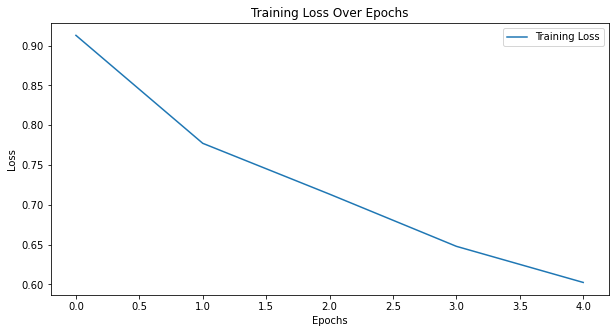

In [11]:
import matplotlib.pyplot as plt

# Plot Training Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()